<a href="https://colab.research.google.com/github/SasikiranJ/Mini_Project/blob/master/Mini_Project_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data = drive.CreateFile({'id': '1IjPMJwqTnBqudAknbwpAn558uTvi0BmT'})
train_bottle = drive.CreateFile({'id' : '1cbB6IA5vk8zoy1JgR23QLD88LvJk6Ps_'})
test_bottle = drive.CreateFile({'id' : '1tSI9oO7MrkpcF7ZJA3JK5w4BHprNFJv1'})
val_bottle = drive.CreateFile({'id' : '1BErplb3uBqEXyhf2VvJbMwrepsObGqQ7'})

In [0]:
data.GetContentFile('OCT.zip')
train_bottle.GetContentFile('bottleneck_features_train.npy')
test_bottle.GetContentFile('bottleneck_features_test.npy')
val_bottle.GetContentFile('bottleneck_features_validation.npy')


In [0]:
!unzip OCT.zip

In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential,load_model
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras.layers import LeakyReLU
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
#Default dimensions we found online
img_width, img_height = 224,224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'OCT/train'  
validation_data_dir = 'OCT/val'  
test_data_dir = 'OCT/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50

In [0]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
'''start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [0]:
'''start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 32 images belonging to 4 classes.
Time:  0:00:03.437008


In [0]:
'''start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1000 images belonging to 4 classes.
Time:  0:00:09.854932


In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 108277 images belonging to 4 classes.


In [9]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 32 images belonging to 4 classes.


In [10]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1000 images belonging to 4 classes.


In [17]:
#This is the best model we found
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))
 
model.add(Dense(100)) 
model.add(LeakyReLU(alpha = 0.3)) 

model.add(Dropout(0.5))  

model.add(Dense(50))
model.add(LeakyReLU(alpha = 0.3))

model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  
callbacks = [EarlyStopping(monitor='val_loss', patience=8,verbose=1,mode='auto'),
             ModelCheckpoint(filepath=top_model_weights_path, monitor='val_loss',verbose=1, save_best_only=True)]


history = model.fit(train_data, train_labels,
      epochs=30,  
      batch_size=batch_size,
      callbacks= callbacks,  
      validation_data=(validation_data, validation_labels))  

#model.save(top_model_weights_path)  

#(eval_loss, eval_accuracy) = model.evaluate(  
 #validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 108277 samples, validate on 32 samples
Epoch 1/30
108277/108277 [==============================] - 22s 202us/step - loss: 0.4552 - acc: 0.8438 - val_loss: 0.7289 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.72887, saving model to bottleneck_fc_model.h5
Epoch 2/30
108277/108277 [==============================] - 21s 193us/step - loss: 0.3388 - acc: 0.8881 - val_loss: 0.5535 - val_acc: 0.7500

Epoch 00002: val_loss improved from 0.72887 to 0.55349, saving model to bottleneck_fc_model.h5
Epoch 3/30
108277/108277 [==============================] - 21s 192us/step - loss: 0.3075 - acc: 0.8984 - val_loss: 0.5453 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.55349 to 0.54532, saving model to bottleneck_fc_model.h5
Epoch 4/30
108277/108277 [==============================] - 21s 193us/step - loss: 0.2899 - acc: 0.9062 - val_loss: 0.4747 - val_acc: 0.7812

Epoch 00004: val_loss improved from 0.54532 to 0.47473, saving model to bottleneck_fc_model.h5
Epoch 5/

In [18]:
model_opt = load_model("bottleneck_fc_model.h5")
model_opt.summary()
(eval_loss, eval_accuracy) = model_opt.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2508900   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)               

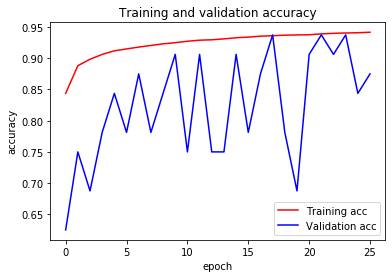

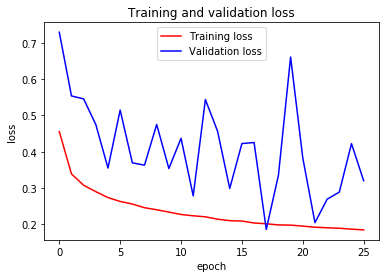

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
model_opt.evaluate(test_data, test_labels)

1000/1000 [==============================] - 0s 127us/step


[0.26885831921547654, 0.901]

In [0]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [0]:
def test_single_image(path):
    clas = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model_opt.predict_proba(bt_prediction)
    for idx, clas, x in zip(range(0,4), clas , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, clas, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model_opt.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [0]:
!ls OCT/val

CNV  DME  DRUSEN  NORMAL


In [0]:
!ls OCT/test/NORMAL

In [0]:
path = "/content/drus.jpg"

In [28]:
!ls out_of_sample

CNV.jpg  DME.jpg  DRUSEN.jpg  normal.jpg


[INFO] loading and preprocessing image...
ID: 0, Label: CNV 80.34%
ID: 1, Label: DME 0.41%
ID: 2, Label: DRUSEN 19.21%
ID: 3, Label: NORMAL 0.04%
Final Decision:
.
..
...
ID: 0, Label: CNV


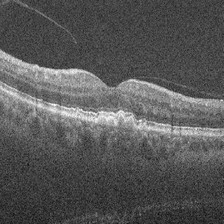

In [46]:
test_single_image(path)

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 99.51%
ID: 1, Label: DME 0.0%
ID: 2, Label: DRUSEN 0.48%
ID: 3, Label: NORMAL 0.0%
Final Decision:
.
..
...
ID: 0, Label: CNV


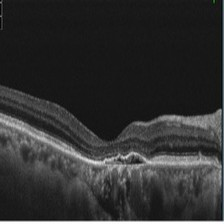

In [47]:
test_single_image("/content/out_of_sample/CNV.jpg")

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 0.0%
ID: 1, Label: DME 100.0%
ID: 2, Label: DRUSEN 0.0%
ID: 3, Label: NORMAL 0.0%
Final Decision:
.
..
...
ID: 1, Label: DME


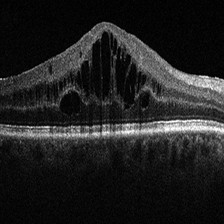

In [48]:
test_single_image("/content/out_of_sample/DME.jpg")

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 0.0%
ID: 1, Label: DME 0.0%
ID: 2, Label: DRUSEN 0.01%
ID: 3, Label: NORMAL 99.99%
Final Decision:
.
..
...
ID: 3, Label: NORMAL


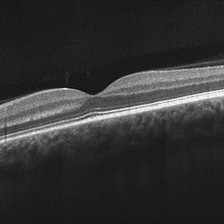

In [49]:
test_single_image("/content/out_of_sample/normal.jpg")